In [19]:
import os
from io import open 

"""Writing the data per file into a dictionary for which the key is the category of news"""

import unicodedata
import string

all_letters = string.ascii_letters + ".,;' "
n_letters = len(all_letters)

def unitoAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readFile_byline(filename):
    line_of_news = open("news_data/"+filename , encoding = 'utf-8').read().split('\n')    
    return [unitoAscii(line) for line in line_of_news]

In [20]:
category_news = {}
all_categories = []

list_of_files = os.listdir("news_data/")

#Dictionary which maps every category of news to it's description
for _file in list_of_files:
    category = _file.split(".")[0]
    all_categories.append(category)
    news_descp = readFile_byline(_file)
    category_news[category] = news_descp

num_categories = len(all_categories)

count_of_news_category = {}
average_words_per_number_of_samples = []

#Counting news items per category of news 
for key in category_news.keys():
    item = category_news.get(key)
    number_of_news_items = len(item)
    count_of_news_category[key] = number_of_news_items
    count_of_words = 0
    for sentence in item:
        count_of_words += len(sentence.split(" "))
    average_words_per_number_of_samples.append(count_of_words/number_of_news_items)

#print(count_of_news_category["WELLNESS"])
#print(category_news["CRIME"][0:2])
#print(average_words_per_number_of_samples)

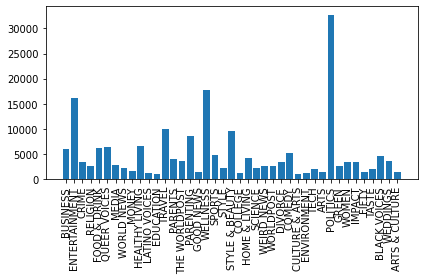

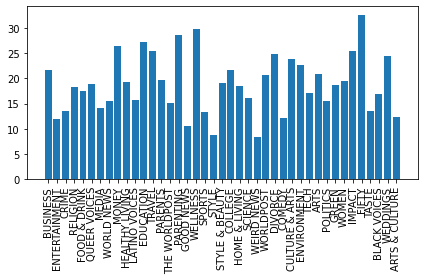

In [21]:
import random
import matplotlib
import matplotlib.pyplot as plt 

fig = plt.figure()
category = count_of_news_category.keys()
value = count_of_news_category.values()
plt.bar(category, value)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Number_of_articles_per_category.png')
plt.show()

fig1 = plt.figure()
category = count_of_news_category.keys()
value = average_words_per_number_of_samples
plt.bar(category, value)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Words_per_category.png')
plt.show()


In [22]:
import torch
import torch.nn as nn 
from torch import optim
import torch.functional as F 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)

def findIndexOfWordInSentence(sentence):
    indexOfWord = {}
    for index, word in enumerate(sentence):
        indexOfWord[word] = index
    return list(indexOfWord.values())

def sentenceToTensor(sentence):
    indexes = findIndexOfWordInSentence(sentence)
    return torch.tensor(indexes , dtype = torch.long, device = device).view(-1, 1)

category_plus_news_list = []

from nltk.corpus import stopwords

for key in category_news.keys():
    for news_item in category_news[key]:
        #news_item = [word for word in news_item.split(" ") if word not in stopwords.words('english')]
        #news_item = " ".join(word for word in news_item)
        category_plus_news_list.append((key, news_item))

print(category_plus_news_list[0])

def pairedTensor(pair):
    #pair is element in category_plus_news_list
    input_tensor = sentenceToTensor(pair[1])
    output_tensor = sentenceToTensor(pair[0])
    return (input_tensor, output_tensor)

#print(pairedTensor(category_plus_news_list[100]))

unique_words = []

'''for pair in category_plus_news_list:
    for word in pair[1].split(" "):
        if word.lower() not in unique_words:
            unique_words.append(word.lower())

print(unique_words[0:50])'''

('BUSINESS', 'The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.')


'for pair in category_plus_news_list:\n    for word in pair[1].split(" "):\n        if word.lower() not in unique_words:\n            unique_words.append(word.lower())\n\nprint(unique_words[0:50])'

In [23]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("bert-base-nli-mean-tokens")




sentence_embeddings = model.encode(category_plus_news_list[0][1])
print(category_plus_news_list[0][1])
print(sentence_embeddings)

The investigation could lead to new U.S. tariffs similar to those imposed on imported steel and aluminum in March.
[ 1.34353526e-02 -1.53605297e-01  1.02039182e+00  3.21564600e-02
  4.77839887e-01 -2.61338532e-01 -7.43478537e-01 -2.43426457e-01
  1.53835759e-01 -8.17684472e-01  3.64184290e-01  1.28729299e-01
  3.75241548e-01  3.49925607e-01 -1.02918398e+00 -5.52589148e-02
 -4.31503147e-01 -7.20983669e-02 -3.03760171e-01 -2.69009024e-02
  1.22883320e-01 -3.95876199e-01  9.66541529e-01  3.75788867e-01
  8.45915318e-01 -1.87337041e-01  1.56129092e-01  2.92605132e-01
 -1.12959194e+00 -7.46736079e-02 -7.90211797e-01  5.23193002e-01
 -7.88372278e-01 -1.45080030e-01  1.27687573e-03  1.40462613e+00
 -7.88551092e-01 -2.69031525e-02 -1.20518543e-01 -3.22462052e-01
 -3.33961189e-01 -2.22803101e-01 -2.82952875e-01  3.03717345e-01
 -1.64360154e+00 -4.25611734e-02  2.37799790e-02  3.83549690e-01
 -1.89633697e-01 -9.51271236e-01  2.90132761e-01  5.24523377e-01
  8.63636136e-02  4.33677018e-01 -2.3412

In [24]:
sentence_embeddings.shape

(768,)

In [25]:
from models import InferSent
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))


use_cuda = True
model = model.to(torch.device('cuda:0')) if use_cuda else model

W2V_PATH = 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)
model.build_vocab_k_words(K=1000000)

Vocab size : 1000000


In [27]:
list_of_sentences_business = []
list_of_sentences_politics = []
list_of_sentences_religion = []
list_of_sentences_food = []
list_of_sentences_home = []

list_of_sentences = []

labels =[]

for pair in category_plus_news_list:
    label = pair[0]
    sentences = pair[1].split(". ")
    for sentence in sentences:
        if len(sentence) >=7:
            list_of_sentences.append(sentence)
            labels.append(label)
    
print(len(list_of_sentences))


for pair in category_plus_news_list:
    if pair[0]=='BUSINESS':
        sentences_business = pair[1].split(". ")
        for sentence in sentences_business:
            list_of_sentences_business.append(sentence)
    if pair[0]=='POLITICS':
        sentences_politics = pair[1].split(". ")
        for sentence in sentences_politics:
            list_of_sentences_politics.append(sentence)
    if pair[0]=='RELIGION':
        sentences_religion = pair[1].split(". ")
        for sentence in sentences_religion:
            list_of_sentences_religion.append(sentence)
    if pair[0]=='FOOD & DRINK':
        sentences_food = pair[1].split(". ")
        for sentence in sentences_food:
            list_of_sentences_food.append(sentence)
    if pair[0]=='HOME & LIVING':
        sentences_home = pair[1].split(". ")
        for sentence in sentences_home:
            list_of_sentences_home.append(sentence)
    
        

262468


In [28]:
#embeddings_business = model.encode(list_of_sentences_business, bsize=128, tokenize=False, verbose=True)
embeddings = model.encode(list_of_sentences, bsize=128, tokenize=False, verbose=True)
#embeddings_politics = model.encode(list_of_sentences_politics, bsize=128, tokenize=False, verbose=True)
#embeddings_religion = model.encode(list_of_sentences_religion, bsize=128, tokenize=False, verbose=True)
#embeddings_food = model.encode(list_of_sentences_food, bsize=128, tokenize=False, verbose=True)
#embeddings_home = model.encode(list_of_sentences_home, bsize=128, tokenize=False, verbose=True)
#print('nb sentences encoded : {0}'.format(len(embeddings_business)))
#print(embeddings_business.shape)
print('nb sentences encoded : {0}'.format(len(embeddings)))
print(embeddings.shape)

Nb words kept : 4007576/4298218 (93.2%)


/scratch/sidray/Attentive-recurrent-neural-networks-for-categorizing-and-generating-news/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


Speed : 4710.7 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 262468
(262468, 4096)


In [29]:
from sklearn.manifold import TSNE
#X_embedded_business = TSNE(n_components = 2, perplexity = 40, n_jobs = -1 ).fit_transform(embeddings_business)
#X_embedded_politics = TSNE(n_components=2).fit_transform(embeddings_politics)
#X_embedded_religion = TSNE(n_components=2).fit_transform(embeddings_religion)
#X_embedded_food = TSNE(n_components=2).fit_transform(embeddings_food)
#print(X_embedded_business.shape)
X_embedded = TSNE(n_components = 2, perplexity = 40, n_jobs = -1).fit_transform(embeddings)
print(X_embedded.shape)

(262468, 2)


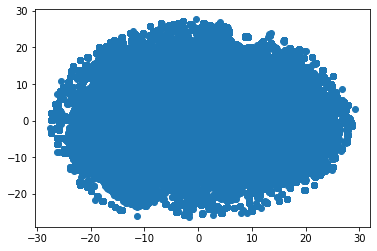

In [13]:
#plt.scatter(X_embedded_business[:,0],X_embedded_business[:,1])
#plt.scatter(X_embedded_religion[:,0],X_embedded_religion[:,1])
#plt.scatter(X_embedded_food[:,0],X_embedded_food[:,1])
#plt.scatter(X_embedded_politics[:,0],X_embedded_politics[:,1])
#plt.scatter(X_embedded_home[:,0],X_embedded_home[:,1])

[0, 0, 0, 0, 0, 0, 0, 0, 0]


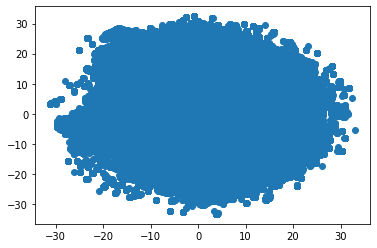

In [43]:
label_list = list(category_news.keys())

for label in labels:
    for idx, value in enumerate(label_list):
        if label == value:
            labels[labels.index(label)] = idx
            


In [118]:
label_list = list(category_news.keys())
index_class_map=[]

for idx, value in enumerate(label_list):
    index_class_map.append((idx,value))

print(index_class_map)
    
    

[(0, 'BUSINESS'), (1, 'ENTERTAINMENT'), (2, 'CRIME'), (3, 'RELIGION'), (4, 'FOOD & DRINK'), (5, 'QUEER VOICES'), (6, 'MEDIA'), (7, 'WORLD NEWS'), (8, 'MONEY'), (9, 'HEALTHY LIVING'), (10, 'LATINO VOICES'), (11, 'EDUCATION'), (12, 'TRAVEL'), (13, 'PARENTS'), (14, 'THE WORLDPOST'), (15, 'PARENTING'), (16, 'GOOD NEWS'), (17, 'WELLNESS'), (18, 'SPORTS'), (19, 'STYLE'), (20, 'STYLE & BEAUTY'), (21, 'COLLEGE'), (22, 'HOME & LIVING'), (23, 'SCIENCE'), (24, 'WEIRD NEWS'), (25, 'WORLDPOST'), (26, 'DIVORCE'), (27, 'COMEDY'), (28, 'CULTURE & ARTS'), (29, 'ENVIRONMENT'), (30, 'TECH'), (31, 'ARTS'), (32, 'POLITICS'), (33, 'GREEN'), (34, 'WOMEN'), (35, 'IMPACT'), (36, 'FIFTY'), (37, 'TASTE'), (38, 'BLACK VOICES'), (39, 'WEDDINGS'), (40, 'ARTS & CULTURE')]


[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
41


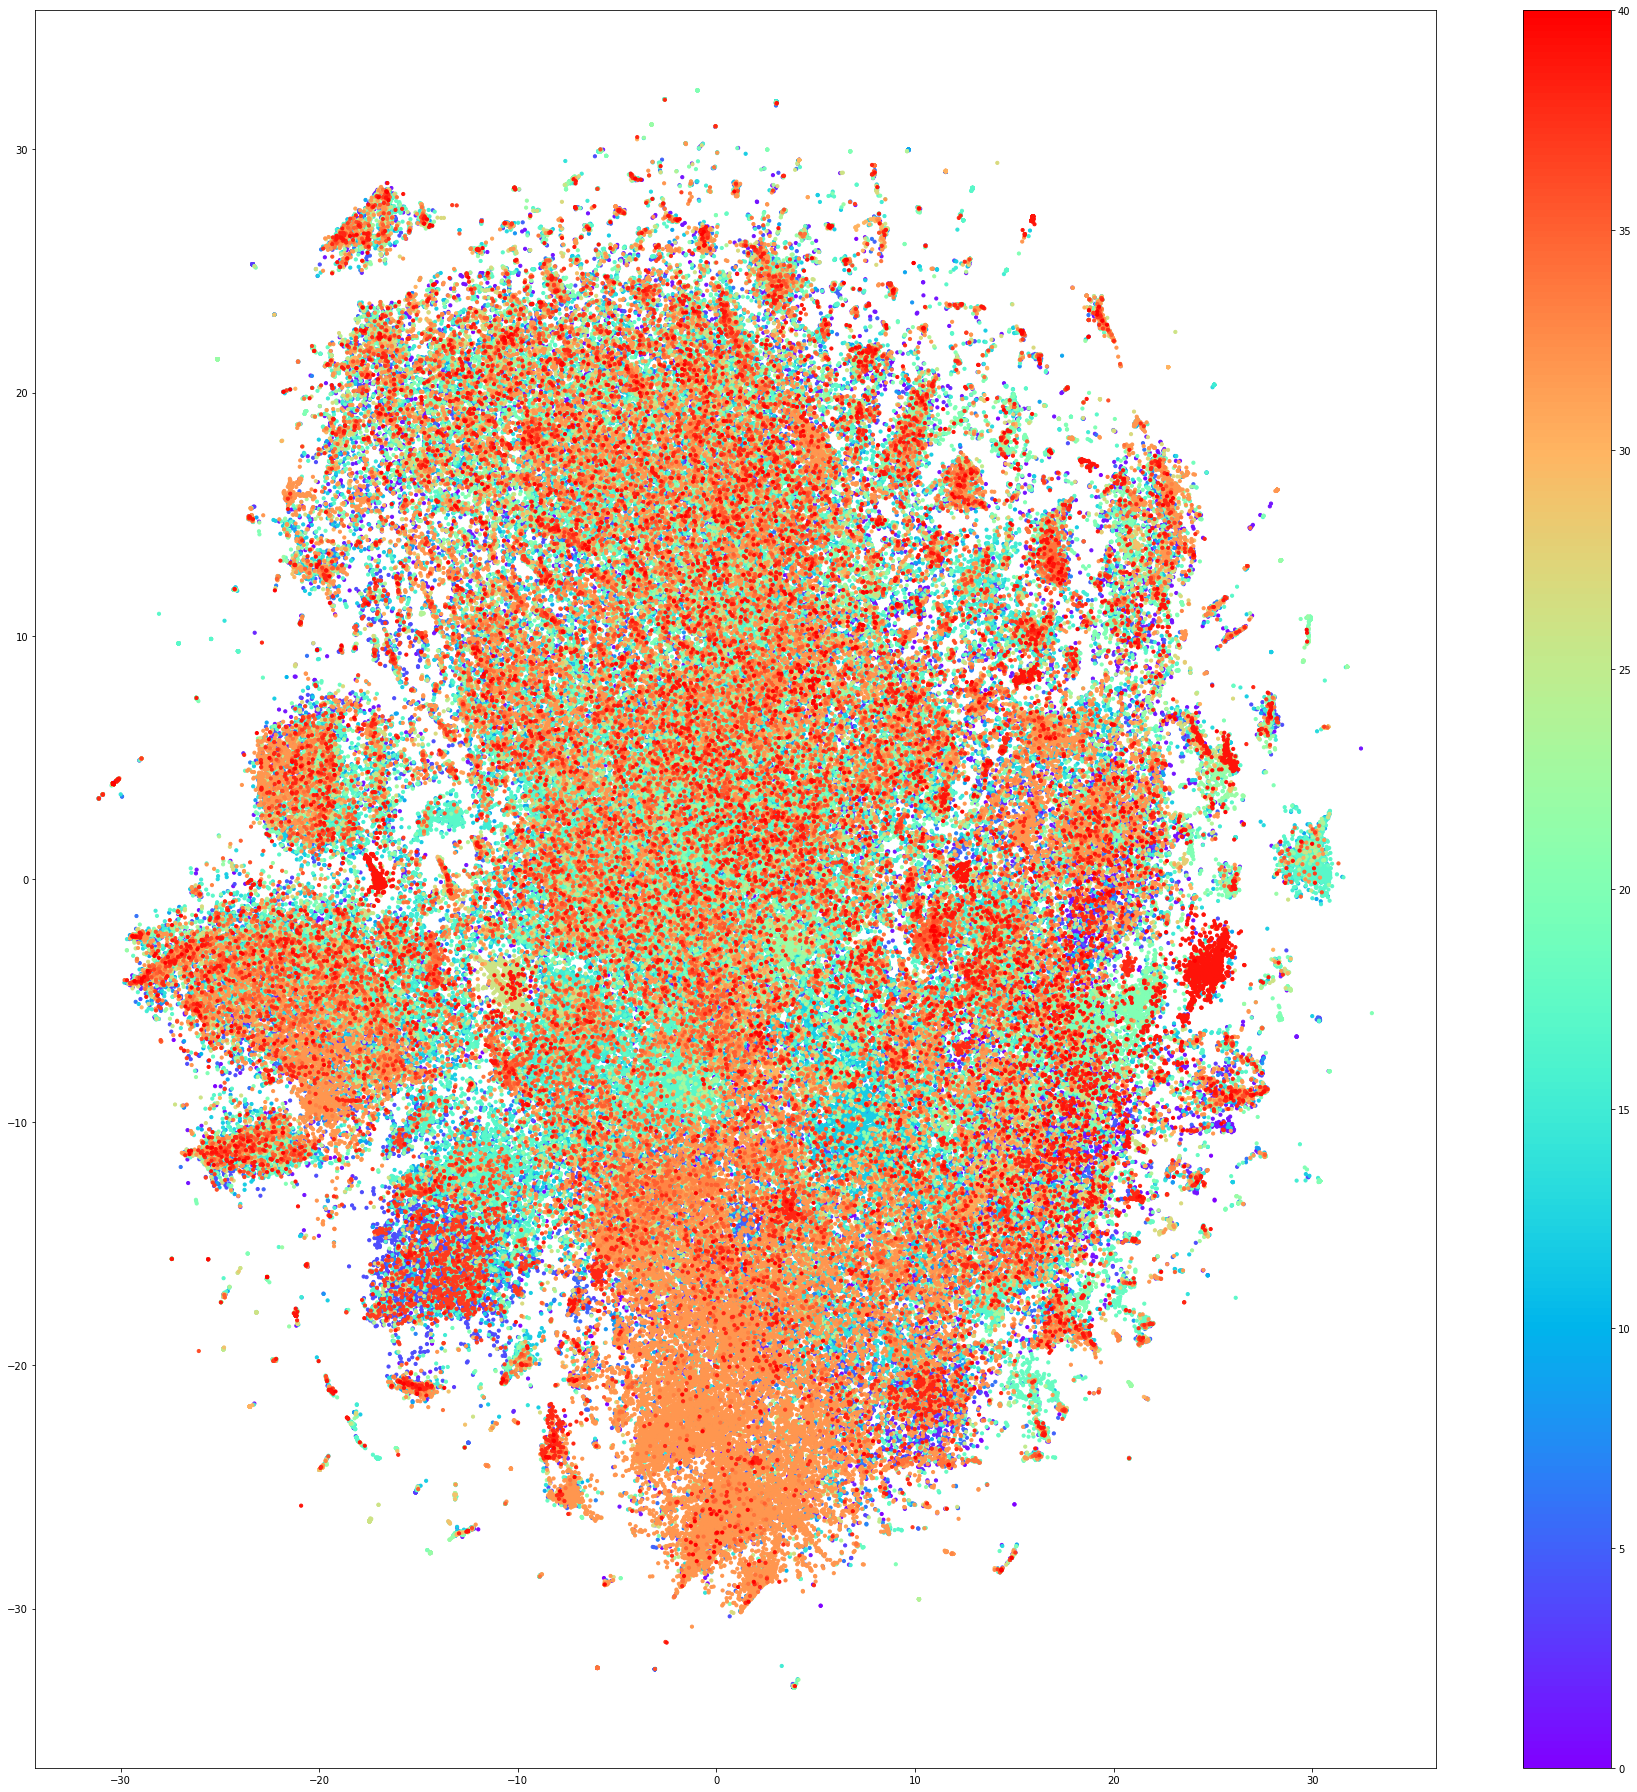

In [120]:
print(labels[99990:100000])
print(len(set(labels)))
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

N = len(set(labels))


fig = plt.figure(figsize=(25,25))
plt.scatter(X_embedded[0:,0],X_embedded[0:,1], 10, c=labels, cmap='rainbow')
plt.colorbar()
plt.tight_layout()
plt.savefig("t-SNE.png")
#pylab.scatter(X_embedded_business[:,0],X_embedded_business[:,1])

In [ ]:
label_list = list(category_news.keys())
fig = plt.figure(figsize=(25,25))
count_0=0
for i in labels:
    if i==0:
        count_0+=1
plt.scatter(X_embedded[:count_0,0],X_embedded[:count_0,1])
